In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [3]:
image_dir_basepath = '../data/images/'
train_path = os.path.join(image_dir_basepath, 'Train')
names = [file for file in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, file))]
print(names)
image_size = 160

threshold = 0.35

['BillGates', 'LarryPage', 'MarkZuckerberg', 'WarrenBuffett']


In [4]:
model_path = '../model/keras/model/facenet_keras.h5'
model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    print("x.ndim: ", x.ndim, x.shape)
    print("size: ", size)

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size)) #3维的标准差调剂值
    y = (x - mean) / std_adj #3维的Z分数标准化
    print("y.shape: ", y.shape)
    return y

In [6]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon)) #对facenet embedding 2次标准化
    return output

In [7]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path) # opencv的哈尔特征人脸对齐算法
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        print("img.shape: ", img.shape)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            print("faces[0]: ",faces[0])

            y1 = max(y-margin//2,0)
            y2 = min(y+h+margin//2,img.shape[0])
            x1 = max(x-margin//2,0)
            x2 = min(x+w+margin//2,img.shape[1])

            #cropped = img[y-margin//2:y+h+margin//2, x-margin//2:x+w+margin//2, :]
            cropped = img[y1:y2,x1:x2,:]
            
            aligned = resize(cropped, (image_size, image_size), mode='reflect') # 转成160*160分辨率
            print("aligned.shape: ", aligned.shape)

            aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [8]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin)) # 返回(file_num, 160, 160, 3)
    embs = np.nan
    
    if len(aligned_images) > 0:
        pd = []
        for start in range(0, len(aligned_images), batch_size):
            attr = model.predict_on_batch(aligned_images[start:start+batch_size]) # 用facenet模型预测对齐后人脸图片的特征 (batch_size, 512)
            print("attr.shape: ",attr.shape)
            pd.append(attr) 
        print("len(pd): ", len(pd))
        embs = l2_normalize(np.concatenate(pd)) # filepaths目录下所有的特征合并

    return embs

In [9]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + 'Train/' + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img] # 训练目录最多每个人脸10张照片
        print("filepaths: ", filepaths)
        embs_ = calc_embs(filepaths)    # 计算name的embedding值
        
        print("embs_: ",embs_.shape, embs_)
        print("name: ",name,[name])
        labels.extend([name] * len(embs_))
        embs.append(embs_)
    
    print("labels: ",labels)
    embs = np.concatenate(embs)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    clf = SVC(kernel='linear', probability=True).fit(embs, y)
    return le, clf

In [10]:
def infer(le, clf, filepaths):
    embs = calc_embs(filepaths)
    
    #利用SVM对人脸特征进行分类
    predictions = clf.predict_proba(embs)
    print("predictions: ",predictions)
    best_class_indices = np.argmax(predictions, axis=1) #Returns the indices of the maximum values along an axis.

    pred = le.inverse_transform(best_class_indices)

    best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
    print(pred,best_class_probabilities)

    #print(type(pred),pred.dtype)

    pred[best_class_probabilities < threshold] = "others"

    #pred = le.inverse_transform(clf.predict(embs))
    return pred

In [11]:
def load_and_align_images_multifaces(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path) # opencv的哈尔特征人脸对齐算法
    
    aligned_images_dict = {}
    img_rectangle_dict = {}
    
    for filepath in filepaths:
        aligned_images = []
        img = imread(filepath)
        img_rectangle = img.copy()
        print("img: ",img.shape)
            
        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        for i in range(len(faces)):
            face = faces[i]
            (x, y, w, h) = face
            print("face: ",face)
            
            y1 = max(y-margin//2,0)
            y2 = min(y+h+margin//2,img.shape[0])
            x1 = max(x-margin//2,0)
            x2 = min(x+w+margin//2,img.shape[1])

            #cropped = img[y-margin//2:y+h+margin//2, x-margin//2:x+w+margin//2, :]
            cropped = img[y1:y2,x1:x2,:]
            print("cropped: ",cropped.shape)
            aligned = resize(cropped, (image_size, image_size), mode='reflect')
            aligned_images.append(aligned)
            cv2.rectangle(img_rectangle, (x1, y1), (x2,y2), (0, 0, 255), 2)
            
        print("filepath: ", filepath)
        aligned_images_dict[filepath] = np.array(aligned_images)
        img_rectangle_dict[filepath] = img_rectangle
        
        #plt.imshow(img_rectangle)
        #plt.show()        
    return aligned_images_dict,img_rectangle_dict
    #return 0

In [12]:
def infer_multifaces(le, clf, filepaths):
    pred_dict = {}
    embs_dict = {}

    aligned_images_dict, img_rectangle_dict = load_and_align_images_multifaces(filepaths, margin=10)

    for filepath in filepaths:
        aligned_images = prewhiten(aligned_images_dict[filepath])
        #pd = []
        #for start in range(0, len(aligned_images), batch_size):
        #    pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
        #embs = l2_normalize(np.concatenate(pd))
        
        pd_ = model.predict_on_batch(aligned_images)
        embs = l2_normalize(pd_)
        embs_dict[filepath] = embs
        
        plt.imshow(img_rectangle_dict[filepath])

        #利用SVM对人脸特征进行分类
        predictions = clf.predict_proba((embs_dict[filepath]))
        best_class_indices = np.argmax(predictions, axis=1) #Returns the indices of the maximum values along an axis.

        pred = le.inverse_transform(best_class_indices)
        
        best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
        print(pred,best_class_probabilities)
        
        print(type(pred),pred.dtype)
        
        pred[best_class_probabilities < threshold] = "others"
        
        #pred = le.inverse_transform(clf.predict(embs_dict[filepath]))
        pred_dict[filepath] = pred
        

        fig, axes = plt.subplots(1, 4, figsize=(12.8, 1.8))

        for i in range(len(pred)):
            axes[i].set_title('Prediction : '+str(pred[i]))
            axes[i].imshow(aligned_images_dict[filepath][i])
            axes[i].set_xticks([])
            axes[i].set_yticks([])
        plt.show()
        
    return pred_dict

In [19]:
le, clf = train(image_dir_basepath, names)

filepaths:  ['/tf/AIface/keras-facenet/data/images/Train/BillGates/Bill_Gates_0000.jpg', '/tf/AIface/keras-facenet/data/images/Train/BillGates/Bill_Gates_0001.jpg', '/tf/AIface/keras-facenet/data/images/Train/BillGates/Bill_Gates_0002.jpg']
img.shape:  (400, 400, 3)
faces[0]:  [103  90 186 186]
aligned.shape:  (160, 160, 3)
img.shape:  (800, 1200, 3)
faces[0]:  [524 138 299 299]
aligned.shape:  (160, 160, 3)
img.shape:  (627, 1200, 3)
faces[0]:  [418  84 384 384]
aligned.shape:  (160, 160, 3)
x.ndim:  4 (3, 160, 160, 3)
size:  76800
y.shape:  (3, 160, 160, 3)
attr.shape:  (1, 512)
attr.shape:  (1, 512)
attr.shape:  (1, 512)
len(pd):  3
embs_:  (3, 512) [[-0.00079599  0.01296401  0.04798979 ...  0.029974   -0.06345469
  -0.00462464]
 [ 0.03399343  0.00808179  0.00729614 ... -0.00161244 -0.07009704
  -0.03686079]
 [ 0.02409041  0.01975369 -0.05600575 ... -0.02278789 -0.07166218
   0.0521769 ]]
name:  BillGates ['BillGates']
filepaths:  ['/tf/AIface/keras-facenet/data/images/Train/LarryPa

In [20]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]
print(test_filepaths)

['../data/images/Test/test0.jpg', '../data/images/Test/test1.jpg', '../data/images/Test/test2.jpg']


In [21]:
pred = infer(le, clf, test_filepaths)

img.shape:  (325, 630, 3)
faces[0]:  [125   9 265 265]
aligned.shape:  (160, 160, 3)
img.shape:  (769, 1025, 3)
faces[0]:  [449  97 158 158]
aligned.shape:  (160, 160, 3)
img.shape:  (2000, 3000, 3)
faces[0]:  [1237  245  950  950]
aligned.shape:  (160, 160, 3)
x.ndim:  4 (3, 160, 160, 3)
size:  76800
y.shape:  (3, 160, 160, 3)
attr.shape:  (1, 512)
attr.shape:  (1, 512)
attr.shape:  (1, 512)
len(pd):  3
predictions:  [[0.60150563 0.17443531 0.14407546 0.0799836 ]
 [0.03559332 0.84409412 0.03857946 0.0817331 ]
 [0.10924264 0.01997898 0.83203192 0.03874646]]
['BillGates' 'LarryPage' 'MarkZuckerberg'] [0.60150563 0.84409412 0.83203192]


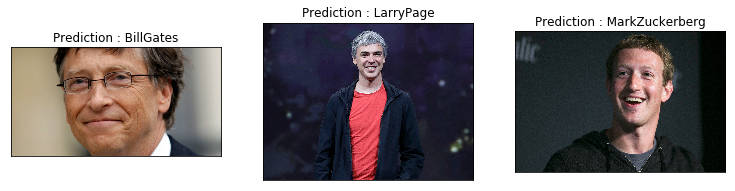

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12.8, 4.8))

for i in range(3):
    axes[i].set_title('Prediction : '+str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [23]:
test_dirpath1 = os.path.join(image_dir_basepath, 'MultiTest')
test_filepaths1 = [os.path.join(test_dirpath1, f) for f in os.listdir(test_dirpath1)]
print(test_filepaths1)

['../data/images/MultiTest/fourin1.jpg', '../data/images/MultiTest/threein1.jpg']


img:  (300, 536, 3)
face:  [120  35 167 167]
cropped:  (177, 177, 3)
face:  [  3  51 122 122]
cropped:  (132, 130, 3)
face:  [281  56 136 136]
cropped:  (146, 146, 3)
face:  [380  83 130 130]
cropped:  (140, 140, 3)
filepath:  ../data/images/MultiTest/fourin1.jpg
img:  (300, 500, 3)
face:  [  5  40 148 148]
cropped:  (158, 158, 3)
face:  [177  55 124 124]
cropped:  (134, 134, 3)
face:  [360  55 138 138]
cropped:  (148, 145, 3)
filepath:  ../data/images/MultiTest/threein1.jpg
x.ndim:  4 (4, 160, 160, 3)
size:  76800
y.shape:  (4, 160, 160, 3)
['MarkZuckerberg' 'BillGates' 'MarkZuckerberg' 'MarkZuckerberg'] [0.4124469  0.55016189 0.83390701 0.30012823]
<class 'numpy.ndarray'> <U14


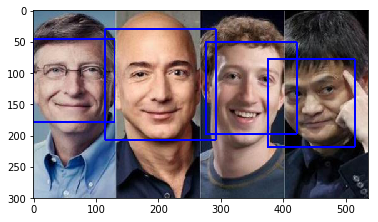

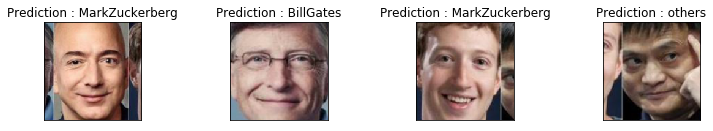

x.ndim:  4 (3, 160, 160, 3)
size:  76800
y.shape:  (3, 160, 160, 3)
['WarrenBuffett' 'BillGates' 'MarkZuckerberg'] [0.76030294 0.71850404 0.88050243]
<class 'numpy.ndarray'> <U14


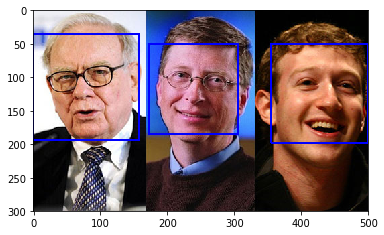

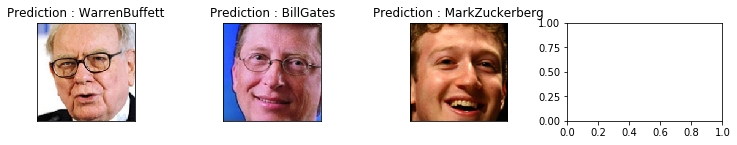

In [24]:
pred = infer_multifaces(le, clf, test_filepaths1)